In [1]:
from z3 import *
import numpy as np
import re
import arviz as az
import pandas as pd
import itertools
import random
import operator # TODO: check this library

import os, sys
sys.path.append(os.path.join("../../../"))

from src.mcmc_sat import smt, mcmc, sat, utils

In [2]:
#32 Haplotypes
#5 placings in the haplotype (2⁵ = 32)
#100 genotypes

haplotypes = list(map(list, itertools.product([0, 1], repeat=5)))
haplotypesProb = [0.0056,0.004,0.00368,0.1,0.005681,0.09,0.00468,0.003,0.08,0.006147,0.00595,0.0071,0.00345,0.00632,0.1,0.0029,0.0071,0.006147,0.085,0.0045671,0.003379,0.1,0.00461,0.00614,0.075,0.08,0.00761,0.004321,0.09,0.009217900000000112,0.0134,0.075]

In [3]:
min(haplotypesProb)

0.0029

In [4]:
sum([0.1,0.09,0.08,0.1,0.085,0.1,0.075,0.08,0.09,0.075])

0.8749999999999999

In [5]:
haplotypesnumber = {}
for i in range(32):
    haplotypesnumber[str(haplotypes[i])] = 0

In [6]:
genotypes = []
random.seed(2023)
for i in range(100):
    h1 = np.random.choice(np.arange(32), p=haplotypesProb)
    h2 = np.random.choice(np.arange(32), p=haplotypesProb)
    genotypes.append(list(map(operator.add,haplotypes[h1],haplotypes[h2])))
    haplotypesnumber[str(haplotypes[h1])] = haplotypesnumber[str(haplotypes[h1])] +1
    haplotypesnumber[str(haplotypes[h2])] = haplotypesnumber[str(haplotypes[h2])] +1

In [7]:
haplotypesnumber

{'[0, 0, 0, 0, 0]': 1,
 '[0, 0, 0, 0, 1]': 1,
 '[0, 0, 0, 1, 0]': 0,
 '[0, 0, 0, 1, 1]': 22,
 '[0, 0, 1, 0, 0]': 1,
 '[0, 0, 1, 0, 1]': 17,
 '[0, 0, 1, 1, 0]': 0,
 '[0, 0, 1, 1, 1]': 0,
 '[0, 1, 0, 0, 0]': 22,
 '[0, 1, 0, 0, 1]': 0,
 '[0, 1, 0, 1, 0]': 3,
 '[0, 1, 0, 1, 1]': 1,
 '[0, 1, 1, 0, 0]': 1,
 '[0, 1, 1, 0, 1]': 0,
 '[0, 1, 1, 1, 0]': 19,
 '[0, 1, 1, 1, 1]': 1,
 '[1, 0, 0, 0, 0]': 2,
 '[1, 0, 0, 0, 1]': 1,
 '[1, 0, 0, 1, 0]': 19,
 '[1, 0, 0, 1, 1]': 1,
 '[1, 0, 1, 0, 0]': 0,
 '[1, 0, 1, 0, 1]': 21,
 '[1, 0, 1, 1, 0]': 1,
 '[1, 0, 1, 1, 1]': 1,
 '[1, 1, 0, 0, 0]': 11,
 '[1, 1, 0, 0, 1]': 10,
 '[1, 1, 0, 1, 0]': 0,
 '[1, 1, 0, 1, 1]': 1,
 '[1, 1, 1, 0, 0]': 22,
 '[1, 1, 1, 0, 1]': 3,
 '[1, 1, 1, 1, 0]': 4,
 '[1, 1, 1, 1, 1]': 14}

In [8]:
# Assumption, all bit-vectors are of the same size
num_bits = 2
num_vars = 5*100*2
var_list = [BitVec(f'x{i}',num_bits) for i in range(num_vars)]
x = var_list
g = Goal()
sat.add_bool_vars_to_goal(g, var_list)

#Add contraints
for i in range(num_vars):
    g.add(ULE(x[i],1))

for i in range(100): # where does the 100 come from?
    for j in range(5): # where does the 5 come from?
        g.add(x[i*10+j] + x[i*10+j+5] == genotypes[i][j])

In [9]:
trace = mcmc.sample_mh_trace_from_z3_model(backend='spur',
                                           z3_problem=g,
                                           num_vars=num_vars,
                                           num_bits=num_bits,
                                           num_samples=10000, 
                                           num_chains=4)

[x7600 = True,
 x7330 = True,
 x6470 = False,
 x1560 = False,
 x5500 = True,
 x5420 = True,
 x6310 = True,
 x8100 = True,
 x8440 = True,
 x6980 = False,
 x1800 = True,
 x2000 = True,
 x2880 = False,
 x7470 = False,
 x8070 = False,
 x5610 = True,
 x7700 = True,
 x4370 = False,
 x6040 = True,
 x2260 = False,
 x2420 = True,
 x760 = False,
 x9800 = True,
 x6380 = False,
 x3230 = True,
 x3970 = False,
 x4290 = False,
 x2670 = False,
 x7110 = True,
 x7800 = True,
 x9440 = True,
 x6710 = True,
 x1200 = True,
 x1250 = False,
 x8670 = False,
 x4750 = False,
 x6760 = False,
 x2010 = True,
 x6970 = False,
 x7950 = False,
 x9010 = True,
 x2060 = False,
 x1180 = False,
 x5530 = True,
 x7290 = False,
 x1680 = False,
 x5390 = False,
 x2480 = False,
 x2600 = True,
 x2820 = True,
 x8940 = True,
 x3290 = False,
 x5070 = False,
 x8620 = True,
 x1290 = False,
 x8720 = True,
 x2290 = False,
 x8490 = False,
 x8960 = False,
 x3920 = True,
 x780 = False,
 x3350 = False,
 x9240 = True,
 x9250 = False,
 x8180 =

Using default filename: "spur_input/samples_z3_problem.txt"
Performing Uniform Model Sampling...
Input File:  spur_input/z3_problem.cnf
Output File: spur_input/samples_z3_problem.txt

Preprocessing ... DONE
variables (all/used/free): 	4625/4625/0
independent support size:  	0
clauses (all/long/binary/unit): 10366/4500/4494/1372
Initialize cache
Size of Cacheable Component:	56
Size of MPZ Class:	16
Maximum cache size:	2399 MB

STAGE #1: Build the initial partial assignments


STAGE #1: COMPLETED building initial partial assignments
STAGE #2 - Filling in partial assignments...
Initialize cache
Size of Cacheable Component:	56
Size of MPZ Class:	16
Maximum cache size:	2399 MB

Sample #1 of 1 is already a complete assignment.  Continuing...
STAGE #2 - COMPLETE




variables (total / active / free)	4625/4625/0
clauses (removed) 		10366 (0)
decisions 				253
conflicts 				0
conflict clauses (all/bin/unit) 	0/0/1372
failed literals found by implicit BCP 	 0
implicit BCP miss rate 	0%
bytes cache size     	20256760	
bytes cache (overall) 	20256760
bytes cache (infra / comps) 20234408/22352	
bytes pure comp data (curr)    6048
bytes pure comp data (overall) 6048
bytes cache with sysoverh (curr)    38696
bytes cache with sysoverh (overall) 38696
cache (stores / hits) 			255/0
cache miss rate 		100%
avg. variable count (stores / hits) 	41.2353/0


# solutions 
14474011154664524427946373126085988481658748083205070504932198000989141204992

# END

time: 15.4433s


Total Sampler Execution Time: 15.4433s

#START_HEADER
start_time,Thu Dec  7 13:09:56 2023
formula_file,spur_input/z3_problem.cnf
num_vars,4625
independent_support_size,0
num_clauses,10366
tot_num_models,14474011154664524427946373126085988481658748083205070504932198000989141204992
max_component

TODO: Determine the right queries for the posterior

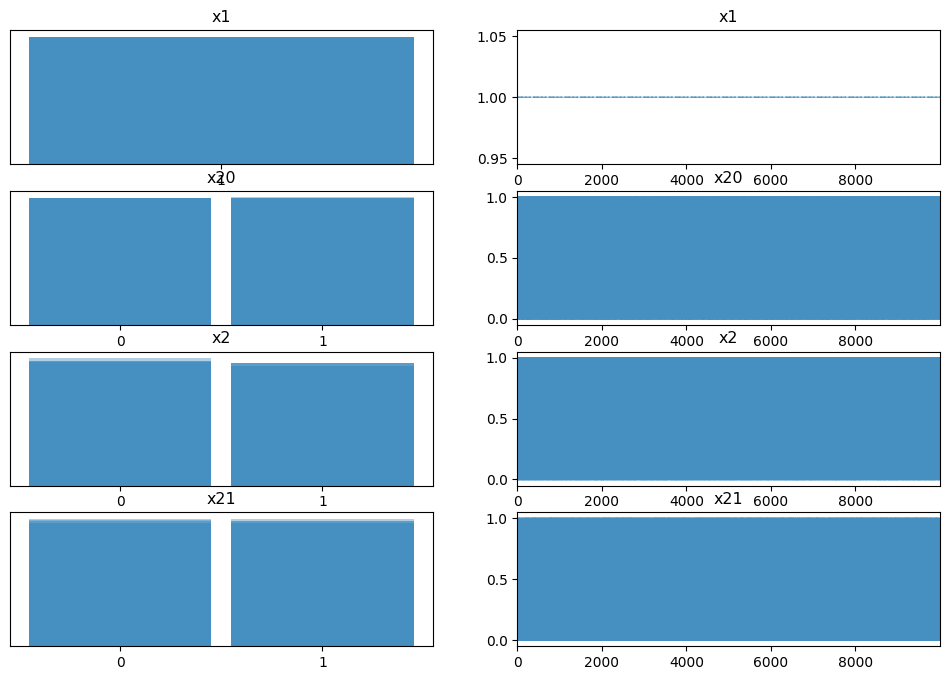

In [10]:
# Plot the posterior
import matplotlib.pyplot as plt
az.plot_trace(trace, var_names=['x1', 'x20', 'x2', 'x21']);
plt.savefig('spur_trace_plot_nz_db.png', dpi=150);

In [11]:
# Diagnostics
az.summary(trace)

/home/pardo/programs/miniconda3/envs/mcmc+sat/lib/python3.11/site-packages/arviz/stats/diagnostics.py:592: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)
/home/pardo/programs/miniconda3/envs/mcmc+sat/lib/python3.11/site-packages/arviz/stats/diagnostics.py:592: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)
/home/pardo/programs/miniconda3/envs/mcmc+sat/lib/python3.11/site-packages/arviz/stats/diagnostics.py:592: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)
/home/pardo/programs/miniconda3/envs/mcmc+sat/lib/python3.11/site-packages/arviz/stats/diagnostics.py:592: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_sampl

/home/pardo/programs/miniconda3/envs/mcmc+sat/lib/python3.11/site-packages/arviz/stats/diagnostics.py:592: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)
/home/pardo/programs/miniconda3/envs/mcmc+sat/lib/python3.11/site-packages/arviz/stats/diagnostics.py:592: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)
/home/pardo/programs/miniconda3/envs/mcmc+sat/lib/python3.11/site-packages/arviz/stats/diagnostics.py:592: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)
/home/pardo/programs/miniconda3/envs/mcmc+sat/lib/python3.11/site-packages/arviz/stats/diagnostics.py:592: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_sampl

/home/pardo/programs/miniconda3/envs/mcmc+sat/lib/python3.11/site-packages/arviz/stats/diagnostics.py:592: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)
/home/pardo/programs/miniconda3/envs/mcmc+sat/lib/python3.11/site-packages/arviz/stats/diagnostics.py:592: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)
/home/pardo/programs/miniconda3/envs/mcmc+sat/lib/python3.11/site-packages/arviz/stats/diagnostics.py:592: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)
/home/pardo/programs/miniconda3/envs/mcmc+sat/lib/python3.11/site-packages/arviz/stats/diagnostics.py:592: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_sampl

/home/pardo/programs/miniconda3/envs/mcmc+sat/lib/python3.11/site-packages/arviz/stats/diagnostics.py:592: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)
/home/pardo/programs/miniconda3/envs/mcmc+sat/lib/python3.11/site-packages/arviz/stats/diagnostics.py:592: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)
/home/pardo/programs/miniconda3/envs/mcmc+sat/lib/python3.11/site-packages/arviz/stats/diagnostics.py:592: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)


/home/pardo/programs/miniconda3/envs/mcmc+sat/lib/python3.11/site-packages/arviz/stats/diagnostics.py:592: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)
/home/pardo/programs/miniconda3/envs/mcmc+sat/lib/python3.11/site-packages/arviz/stats/diagnostics.py:592: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)
/home/pardo/programs/miniconda3/envs/mcmc+sat/lib/python3.11/site-packages/arviz/stats/diagnostics.py:592: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)
/home/pardo/programs/miniconda3/envs/mcmc+sat/lib/python3.11/site-packages/arviz/stats/diagnostics.py:592: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_sampl

/home/pardo/programs/miniconda3/envs/mcmc+sat/lib/python3.11/site-packages/arviz/stats/diagnostics.py:592: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)
/home/pardo/programs/miniconda3/envs/mcmc+sat/lib/python3.11/site-packages/arviz/stats/diagnostics.py:592: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)
/home/pardo/programs/miniconda3/envs/mcmc+sat/lib/python3.11/site-packages/arviz/stats/diagnostics.py:592: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)
/home/pardo/programs/miniconda3/envs/mcmc+sat/lib/python3.11/site-packages/arviz/stats/diagnostics.py:592: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_sampl

/home/pardo/programs/miniconda3/envs/mcmc+sat/lib/python3.11/site-packages/arviz/stats/diagnostics.py:592: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)
/home/pardo/programs/miniconda3/envs/mcmc+sat/lib/python3.11/site-packages/arviz/stats/diagnostics.py:592: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)
/home/pardo/programs/miniconda3/envs/mcmc+sat/lib/python3.11/site-packages/arviz/stats/diagnostics.py:592: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)
/home/pardo/programs/miniconda3/envs/mcmc+sat/lib/python3.11/site-packages/arviz/stats/diagnostics.py:592: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_sampl

/home/pardo/programs/miniconda3/envs/mcmc+sat/lib/python3.11/site-packages/arviz/stats/diagnostics.py:592: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)
/home/pardo/programs/miniconda3/envs/mcmc+sat/lib/python3.11/site-packages/arviz/stats/diagnostics.py:592: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)
/home/pardo/programs/miniconda3/envs/mcmc+sat/lib/python3.11/site-packages/arviz/stats/diagnostics.py:592: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)
/home/pardo/programs/miniconda3/envs/mcmc+sat/lib/python3.11/site-packages/arviz/stats/diagnostics.py:592: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_sampl

/home/pardo/programs/miniconda3/envs/mcmc+sat/lib/python3.11/site-packages/arviz/stats/diagnostics.py:592: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)
/home/pardo/programs/miniconda3/envs/mcmc+sat/lib/python3.11/site-packages/arviz/stats/diagnostics.py:592: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)
/home/pardo/programs/miniconda3/envs/mcmc+sat/lib/python3.11/site-packages/arviz/stats/diagnostics.py:592: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)
/home/pardo/programs/miniconda3/envs/mcmc+sat/lib/python3.11/site-packages/arviz/stats/diagnostics.py:592: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_sampl

/home/pardo/programs/miniconda3/envs/mcmc+sat/lib/python3.11/site-packages/arviz/stats/diagnostics.py:592: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)
/home/pardo/programs/miniconda3/envs/mcmc+sat/lib/python3.11/site-packages/arviz/stats/diagnostics.py:592: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)
/home/pardo/programs/miniconda3/envs/mcmc+sat/lib/python3.11/site-packages/arviz/stats/diagnostics.py:592: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)
/home/pardo/programs/miniconda3/envs/mcmc+sat/lib/python3.11/site-packages/arviz/stats/diagnostics.py:592: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_sampl

/home/pardo/programs/miniconda3/envs/mcmc+sat/lib/python3.11/site-packages/arviz/stats/diagnostics.py:592: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)
/home/pardo/programs/miniconda3/envs/mcmc+sat/lib/python3.11/site-packages/arviz/stats/diagnostics.py:592: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)
/home/pardo/programs/miniconda3/envs/mcmc+sat/lib/python3.11/site-packages/arviz/stats/diagnostics.py:592: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)
/home/pardo/programs/miniconda3/envs/mcmc+sat/lib/python3.11/site-packages/arviz/stats/diagnostics.py:592: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_sampl

/home/pardo/programs/miniconda3/envs/mcmc+sat/lib/python3.11/site-packages/arviz/stats/diagnostics.py:592: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)
/home/pardo/programs/miniconda3/envs/mcmc+sat/lib/python3.11/site-packages/arviz/stats/diagnostics.py:592: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)
/home/pardo/programs/miniconda3/envs/mcmc+sat/lib/python3.11/site-packages/arviz/stats/diagnostics.py:592: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)
/home/pardo/programs/miniconda3/envs/mcmc+sat/lib/python3.11/site-packages/arviz/stats/diagnostics.py:592: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_sampl

/home/pardo/programs/miniconda3/envs/mcmc+sat/lib/python3.11/site-packages/arviz/stats/diagnostics.py:592: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)
/home/pardo/programs/miniconda3/envs/mcmc+sat/lib/python3.11/site-packages/arviz/stats/diagnostics.py:592: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)
/home/pardo/programs/miniconda3/envs/mcmc+sat/lib/python3.11/site-packages/arviz/stats/diagnostics.py:592: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)
/home/pardo/programs/miniconda3/envs/mcmc+sat/lib/python3.11/site-packages/arviz/stats/diagnostics.py:592: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_sampl

/home/pardo/programs/miniconda3/envs/mcmc+sat/lib/python3.11/site-packages/arviz/stats/diagnostics.py:592: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)
/home/pardo/programs/miniconda3/envs/mcmc+sat/lib/python3.11/site-packages/arviz/stats/diagnostics.py:592: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)
/home/pardo/programs/miniconda3/envs/mcmc+sat/lib/python3.11/site-packages/arviz/stats/diagnostics.py:592: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)
/home/pardo/programs/miniconda3/envs/mcmc+sat/lib/python3.11/site-packages/arviz/stats/diagnostics.py:592: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_sampl

/home/pardo/programs/miniconda3/envs/mcmc+sat/lib/python3.11/site-packages/arviz/stats/diagnostics.py:592: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)
/home/pardo/programs/miniconda3/envs/mcmc+sat/lib/python3.11/site-packages/arviz/stats/diagnostics.py:592: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)
/home/pardo/programs/miniconda3/envs/mcmc+sat/lib/python3.11/site-packages/arviz/stats/diagnostics.py:592: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)
/home/pardo/programs/miniconda3/envs/mcmc+sat/lib/python3.11/site-packages/arviz/stats/diagnostics.py:592: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_sampl

/home/pardo/programs/miniconda3/envs/mcmc+sat/lib/python3.11/site-packages/arviz/stats/diagnostics.py:592: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)
/home/pardo/programs/miniconda3/envs/mcmc+sat/lib/python3.11/site-packages/arviz/stats/diagnostics.py:592: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)
/home/pardo/programs/miniconda3/envs/mcmc+sat/lib/python3.11/site-packages/arviz/stats/diagnostics.py:592: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)
/home/pardo/programs/miniconda3/envs/mcmc+sat/lib/python3.11/site-packages/arviz/stats/diagnostics.py:592: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_sampl

/home/pardo/programs/miniconda3/envs/mcmc+sat/lib/python3.11/site-packages/arviz/stats/diagnostics.py:592: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)
/home/pardo/programs/miniconda3/envs/mcmc+sat/lib/python3.11/site-packages/arviz/stats/diagnostics.py:592: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)
/home/pardo/programs/miniconda3/envs/mcmc+sat/lib/python3.11/site-packages/arviz/stats/diagnostics.py:592: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)
/home/pardo/programs/miniconda3/envs/mcmc+sat/lib/python3.11/site-packages/arviz/stats/diagnostics.py:592: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_sampl

/home/pardo/programs/miniconda3/envs/mcmc+sat/lib/python3.11/site-packages/arviz/stats/diagnostics.py:592: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)
/home/pardo/programs/miniconda3/envs/mcmc+sat/lib/python3.11/site-packages/arviz/stats/diagnostics.py:592: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)
/home/pardo/programs/miniconda3/envs/mcmc+sat/lib/python3.11/site-packages/arviz/stats/diagnostics.py:592: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)
/home/pardo/programs/miniconda3/envs/mcmc+sat/lib/python3.11/site-packages/arviz/stats/diagnostics.py:592: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_sampl

/home/pardo/programs/miniconda3/envs/mcmc+sat/lib/python3.11/site-packages/arviz/stats/diagnostics.py:592: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)
/home/pardo/programs/miniconda3/envs/mcmc+sat/lib/python3.11/site-packages/arviz/stats/diagnostics.py:592: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)


/home/pardo/programs/miniconda3/envs/mcmc+sat/lib/python3.11/site-packages/arviz/stats/diagnostics.py:592: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)
/home/pardo/programs/miniconda3/envs/mcmc+sat/lib/python3.11/site-packages/arviz/stats/diagnostics.py:592: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)
/home/pardo/programs/miniconda3/envs/mcmc+sat/lib/python3.11/site-packages/arviz/stats/diagnostics.py:592: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)
/home/pardo/programs/miniconda3/envs/mcmc+sat/lib/python3.11/site-packages/arviz/stats/diagnostics.py:592: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_sampl

/home/pardo/programs/miniconda3/envs/mcmc+sat/lib/python3.11/site-packages/arviz/stats/diagnostics.py:592: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)
/home/pardo/programs/miniconda3/envs/mcmc+sat/lib/python3.11/site-packages/arviz/stats/diagnostics.py:592: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)
/home/pardo/programs/miniconda3/envs/mcmc+sat/lib/python3.11/site-packages/arviz/stats/diagnostics.py:592: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)
/home/pardo/programs/miniconda3/envs/mcmc+sat/lib/python3.11/site-packages/arviz/stats/diagnostics.py:592: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_sampl

/home/pardo/programs/miniconda3/envs/mcmc+sat/lib/python3.11/site-packages/arviz/stats/diagnostics.py:592: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)
/home/pardo/programs/miniconda3/envs/mcmc+sat/lib/python3.11/site-packages/arviz/stats/diagnostics.py:592: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)
/home/pardo/programs/miniconda3/envs/mcmc+sat/lib/python3.11/site-packages/arviz/stats/diagnostics.py:592: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)
/home/pardo/programs/miniconda3/envs/mcmc+sat/lib/python3.11/site-packages/arviz/stats/diagnostics.py:592: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_sampl

/home/pardo/programs/miniconda3/envs/mcmc+sat/lib/python3.11/site-packages/arviz/stats/diagnostics.py:592: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)
/home/pardo/programs/miniconda3/envs/mcmc+sat/lib/python3.11/site-packages/arviz/stats/diagnostics.py:592: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)
/home/pardo/programs/miniconda3/envs/mcmc+sat/lib/python3.11/site-packages/arviz/stats/diagnostics.py:592: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)
/home/pardo/programs/miniconda3/envs/mcmc+sat/lib/python3.11/site-packages/arviz/stats/diagnostics.py:592: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_sampl

/home/pardo/programs/miniconda3/envs/mcmc+sat/lib/python3.11/site-packages/arviz/stats/diagnostics.py:592: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)
/home/pardo/programs/miniconda3/envs/mcmc+sat/lib/python3.11/site-packages/arviz/stats/diagnostics.py:592: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)
/home/pardo/programs/miniconda3/envs/mcmc+sat/lib/python3.11/site-packages/arviz/stats/diagnostics.py:592: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)
/home/pardo/programs/miniconda3/envs/mcmc+sat/lib/python3.11/site-packages/arviz/stats/diagnostics.py:592: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_sampl

/home/pardo/programs/miniconda3/envs/mcmc+sat/lib/python3.11/site-packages/arviz/stats/diagnostics.py:592: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)
/home/pardo/programs/miniconda3/envs/mcmc+sat/lib/python3.11/site-packages/arviz/stats/diagnostics.py:592: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)
/home/pardo/programs/miniconda3/envs/mcmc+sat/lib/python3.11/site-packages/arviz/stats/diagnostics.py:592: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)
/home/pardo/programs/miniconda3/envs/mcmc+sat/lib/python3.11/site-packages/arviz/stats/diagnostics.py:592: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_sampl

/home/pardo/programs/miniconda3/envs/mcmc+sat/lib/python3.11/site-packages/arviz/stats/diagnostics.py:592: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)
/home/pardo/programs/miniconda3/envs/mcmc+sat/lib/python3.11/site-packages/arviz/stats/diagnostics.py:592: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)
/home/pardo/programs/miniconda3/envs/mcmc+sat/lib/python3.11/site-packages/arviz/stats/diagnostics.py:592: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)


/home/pardo/programs/miniconda3/envs/mcmc+sat/lib/python3.11/site-packages/arviz/stats/diagnostics.py:592: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)
/home/pardo/programs/miniconda3/envs/mcmc+sat/lib/python3.11/site-packages/arviz/stats/diagnostics.py:592: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)
/home/pardo/programs/miniconda3/envs/mcmc+sat/lib/python3.11/site-packages/arviz/stats/diagnostics.py:592: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)
/home/pardo/programs/miniconda3/envs/mcmc+sat/lib/python3.11/site-packages/arviz/stats/diagnostics.py:592: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_sampl

/home/pardo/programs/miniconda3/envs/mcmc+sat/lib/python3.11/site-packages/arviz/stats/diagnostics.py:592: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)
/home/pardo/programs/miniconda3/envs/mcmc+sat/lib/python3.11/site-packages/arviz/stats/diagnostics.py:592: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)


/home/pardo/programs/miniconda3/envs/mcmc+sat/lib/python3.11/site-packages/arviz/stats/diagnostics.py:592: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)
/home/pardo/programs/miniconda3/envs/mcmc+sat/lib/python3.11/site-packages/arviz/stats/diagnostics.py:592: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)
/home/pardo/programs/miniconda3/envs/mcmc+sat/lib/python3.11/site-packages/arviz/stats/diagnostics.py:592: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)
/home/pardo/programs/miniconda3/envs/mcmc+sat/lib/python3.11/site-packages/arviz/stats/diagnostics.py:592: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_sampl

/home/pardo/programs/miniconda3/envs/mcmc+sat/lib/python3.11/site-packages/arviz/stats/diagnostics.py:592: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)
/home/pardo/programs/miniconda3/envs/mcmc+sat/lib/python3.11/site-packages/arviz/stats/diagnostics.py:592: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)
/home/pardo/programs/miniconda3/envs/mcmc+sat/lib/python3.11/site-packages/arviz/stats/diagnostics.py:592: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)
/home/pardo/programs/miniconda3/envs/mcmc+sat/lib/python3.11/site-packages/arviz/stats/diagnostics.py:592: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_sampl

/home/pardo/programs/miniconda3/envs/mcmc+sat/lib/python3.11/site-packages/arviz/stats/diagnostics.py:592: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)
/home/pardo/programs/miniconda3/envs/mcmc+sat/lib/python3.11/site-packages/arviz/stats/diagnostics.py:592: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)
/home/pardo/programs/miniconda3/envs/mcmc+sat/lib/python3.11/site-packages/arviz/stats/diagnostics.py:592: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)
/home/pardo/programs/miniconda3/envs/mcmc+sat/lib/python3.11/site-packages/arviz/stats/diagnostics.py:592: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_sampl

/home/pardo/programs/miniconda3/envs/mcmc+sat/lib/python3.11/site-packages/arviz/stats/diagnostics.py:592: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)
/home/pardo/programs/miniconda3/envs/mcmc+sat/lib/python3.11/site-packages/arviz/stats/diagnostics.py:592: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)
/home/pardo/programs/miniconda3/envs/mcmc+sat/lib/python3.11/site-packages/arviz/stats/diagnostics.py:592: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)


/home/pardo/programs/miniconda3/envs/mcmc+sat/lib/python3.11/site-packages/arviz/stats/diagnostics.py:592: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)
/home/pardo/programs/miniconda3/envs/mcmc+sat/lib/python3.11/site-packages/arviz/stats/diagnostics.py:592: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)
/home/pardo/programs/miniconda3/envs/mcmc+sat/lib/python3.11/site-packages/arviz/stats/diagnostics.py:592: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)
/home/pardo/programs/miniconda3/envs/mcmc+sat/lib/python3.11/site-packages/arviz/stats/diagnostics.py:592: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_sampl

/home/pardo/programs/miniconda3/envs/mcmc+sat/lib/python3.11/site-packages/arviz/stats/diagnostics.py:592: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)
/home/pardo/programs/miniconda3/envs/mcmc+sat/lib/python3.11/site-packages/arviz/stats/diagnostics.py:592: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)
/home/pardo/programs/miniconda3/envs/mcmc+sat/lib/python3.11/site-packages/arviz/stats/diagnostics.py:592: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)
/home/pardo/programs/miniconda3/envs/mcmc+sat/lib/python3.11/site-packages/arviz/stats/diagnostics.py:592: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_sampl

/home/pardo/programs/miniconda3/envs/mcmc+sat/lib/python3.11/site-packages/arviz/stats/diagnostics.py:592: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)
/home/pardo/programs/miniconda3/envs/mcmc+sat/lib/python3.11/site-packages/arviz/stats/diagnostics.py:592: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)
/home/pardo/programs/miniconda3/envs/mcmc+sat/lib/python3.11/site-packages/arviz/stats/diagnostics.py:592: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)
/home/pardo/programs/miniconda3/envs/mcmc+sat/lib/python3.11/site-packages/arviz/stats/diagnostics.py:592: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_sampl

/home/pardo/programs/miniconda3/envs/mcmc+sat/lib/python3.11/site-packages/arviz/stats/diagnostics.py:592: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)
/home/pardo/programs/miniconda3/envs/mcmc+sat/lib/python3.11/site-packages/arviz/stats/diagnostics.py:592: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)
/home/pardo/programs/miniconda3/envs/mcmc+sat/lib/python3.11/site-packages/arviz/stats/diagnostics.py:592: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)
/home/pardo/programs/miniconda3/envs/mcmc+sat/lib/python3.11/site-packages/arviz/stats/diagnostics.py:592: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_sampl

/home/pardo/programs/miniconda3/envs/mcmc+sat/lib/python3.11/site-packages/arviz/stats/diagnostics.py:592: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)
/home/pardo/programs/miniconda3/envs/mcmc+sat/lib/python3.11/site-packages/arviz/stats/diagnostics.py:592: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)
/home/pardo/programs/miniconda3/envs/mcmc+sat/lib/python3.11/site-packages/arviz/stats/diagnostics.py:592: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)
/home/pardo/programs/miniconda3/envs/mcmc+sat/lib/python3.11/site-packages/arviz/stats/diagnostics.py:592: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_sampl

/home/pardo/programs/miniconda3/envs/mcmc+sat/lib/python3.11/site-packages/arviz/stats/diagnostics.py:592: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)
/home/pardo/programs/miniconda3/envs/mcmc+sat/lib/python3.11/site-packages/arviz/stats/diagnostics.py:592: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)
/home/pardo/programs/miniconda3/envs/mcmc+sat/lib/python3.11/site-packages/arviz/stats/diagnostics.py:592: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)
/home/pardo/programs/miniconda3/envs/mcmc+sat/lib/python3.11/site-packages/arviz/stats/diagnostics.py:592: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_sampl

/home/pardo/programs/miniconda3/envs/mcmc+sat/lib/python3.11/site-packages/arviz/stats/diagnostics.py:592: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)
/home/pardo/programs/miniconda3/envs/mcmc+sat/lib/python3.11/site-packages/arviz/stats/diagnostics.py:592: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)
/home/pardo/programs/miniconda3/envs/mcmc+sat/lib/python3.11/site-packages/arviz/stats/diagnostics.py:592: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)
/home/pardo/programs/miniconda3/envs/mcmc+sat/lib/python3.11/site-packages/arviz/stats/diagnostics.py:592: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_sampl

/home/pardo/programs/miniconda3/envs/mcmc+sat/lib/python3.11/site-packages/arviz/stats/diagnostics.py:592: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)
/home/pardo/programs/miniconda3/envs/mcmc+sat/lib/python3.11/site-packages/arviz/stats/diagnostics.py:592: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)
/home/pardo/programs/miniconda3/envs/mcmc+sat/lib/python3.11/site-packages/arviz/stats/diagnostics.py:592: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)
/home/pardo/programs/miniconda3/envs/mcmc+sat/lib/python3.11/site-packages/arviz/stats/diagnostics.py:592: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_sampl

/home/pardo/programs/miniconda3/envs/mcmc+sat/lib/python3.11/site-packages/arviz/stats/diagnostics.py:592: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)
/home/pardo/programs/miniconda3/envs/mcmc+sat/lib/python3.11/site-packages/arviz/stats/diagnostics.py:592: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)
/home/pardo/programs/miniconda3/envs/mcmc+sat/lib/python3.11/site-packages/arviz/stats/diagnostics.py:592: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)
/home/pardo/programs/miniconda3/envs/mcmc+sat/lib/python3.11/site-packages/arviz/stats/diagnostics.py:592: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_sampl

/home/pardo/programs/miniconda3/envs/mcmc+sat/lib/python3.11/site-packages/arviz/stats/diagnostics.py:592: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)
/home/pardo/programs/miniconda3/envs/mcmc+sat/lib/python3.11/site-packages/arviz/stats/diagnostics.py:592: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)
/home/pardo/programs/miniconda3/envs/mcmc+sat/lib/python3.11/site-packages/arviz/stats/diagnostics.py:592: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)
/home/pardo/programs/miniconda3/envs/mcmc+sat/lib/python3.11/site-packages/arviz/stats/diagnostics.py:592: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_sampl

/home/pardo/programs/miniconda3/envs/mcmc+sat/lib/python3.11/site-packages/arviz/stats/diagnostics.py:592: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)
/home/pardo/programs/miniconda3/envs/mcmc+sat/lib/python3.11/site-packages/arviz/stats/diagnostics.py:592: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)
/home/pardo/programs/miniconda3/envs/mcmc+sat/lib/python3.11/site-packages/arviz/stats/diagnostics.py:592: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)
/home/pardo/programs/miniconda3/envs/mcmc+sat/lib/python3.11/site-packages/arviz/stats/diagnostics.py:592: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_sampl

/home/pardo/programs/miniconda3/envs/mcmc+sat/lib/python3.11/site-packages/arviz/stats/diagnostics.py:592: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)
/home/pardo/programs/miniconda3/envs/mcmc+sat/lib/python3.11/site-packages/arviz/stats/diagnostics.py:592: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)
/home/pardo/programs/miniconda3/envs/mcmc+sat/lib/python3.11/site-packages/arviz/stats/diagnostics.py:592: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)
/home/pardo/programs/miniconda3/envs/mcmc+sat/lib/python3.11/site-packages/arviz/stats/diagnostics.py:592: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_sampl

/home/pardo/programs/miniconda3/envs/mcmc+sat/lib/python3.11/site-packages/arviz/stats/diagnostics.py:592: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)
/home/pardo/programs/miniconda3/envs/mcmc+sat/lib/python3.11/site-packages/arviz/stats/diagnostics.py:592: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)
/home/pardo/programs/miniconda3/envs/mcmc+sat/lib/python3.11/site-packages/arviz/stats/diagnostics.py:592: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)
/home/pardo/programs/miniconda3/envs/mcmc+sat/lib/python3.11/site-packages/arviz/stats/diagnostics.py:592: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_sampl

/home/pardo/programs/miniconda3/envs/mcmc+sat/lib/python3.11/site-packages/arviz/stats/diagnostics.py:592: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)
/home/pardo/programs/miniconda3/envs/mcmc+sat/lib/python3.11/site-packages/arviz/stats/diagnostics.py:592: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)
/home/pardo/programs/miniconda3/envs/mcmc+sat/lib/python3.11/site-packages/arviz/stats/diagnostics.py:592: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)
/home/pardo/programs/miniconda3/envs/mcmc+sat/lib/python3.11/site-packages/arviz/stats/diagnostics.py:592: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_sampl

/home/pardo/programs/miniconda3/envs/mcmc+sat/lib/python3.11/site-packages/arviz/stats/diagnostics.py:592: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)
/home/pardo/programs/miniconda3/envs/mcmc+sat/lib/python3.11/site-packages/arviz/stats/diagnostics.py:592: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)
/home/pardo/programs/miniconda3/envs/mcmc+sat/lib/python3.11/site-packages/arviz/stats/diagnostics.py:592: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)
/home/pardo/programs/miniconda3/envs/mcmc+sat/lib/python3.11/site-packages/arviz/stats/diagnostics.py:592: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_sampl

/home/pardo/programs/miniconda3/envs/mcmc+sat/lib/python3.11/site-packages/arviz/stats/diagnostics.py:592: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)
/home/pardo/programs/miniconda3/envs/mcmc+sat/lib/python3.11/site-packages/arviz/stats/diagnostics.py:592: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)
/home/pardo/programs/miniconda3/envs/mcmc+sat/lib/python3.11/site-packages/arviz/stats/diagnostics.py:592: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
x0,0.509,0.5,0.0,1.0,0.003,0.002,39335.0,39335.0,1.0
x1,1.000,0.0,1.0,1.0,0.000,0.000,40000.0,40000.0,NaN
x2,0.493,0.5,0.0,1.0,0.002,0.002,40230.0,40000.0,1.0
x3,0.503,0.5,0.0,1.0,0.003,0.002,39401.0,39401.0,1.0
x4,0.000,0.0,0.0,0.0,0.000,0.000,40000.0,40000.0,NaN
...,...,...,...,...,...,...,...,...,...
x995,0.497,0.5,0.0,1.0,0.002,0.002,40161.0,40000.0,1.0
x996,0.000,0.0,0.0,0.0,0.000,0.000,40000.0,40000.0,NaN
x997,0.500,0.5,0.0,1.0,0.003,0.002,39213.0,39213.0,1.0
x998,0.510,0.5,0.0,1.0,0.003,0.002,39748.0,39748.0,1.0
